# Solución reto Perú - Equipo GANadores

## Importación de librerias y definición de funciones a utilizar

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm_notebook
from catboost import CatBoostClassifier
import lightgbm as lgb
from sklearn.metrics import roc_auc_score
pd.set_option('display.max_columns', None)

In [2]:
import warnings
warnings.filterwarnings('ignore')

In [3]:
#Función para obtener variables con alta correlación
def get_correlated(data, cut=0.85):
    correlated_features = set()
    correlation_matrix = data.corr()
    
    for i in range(len(correlation_matrix .columns)):
        for j in range(i):
            if abs(correlation_matrix.iloc[i, j]) > cut:
                colname = correlation_matrix.columns[i]
                correlated_features.add(colname)
            
    return correlated_features 

#Función para obtener la importancia de variables
def plot_importances(model, X, n_features=-1):
    
    importances = model.feature_importances_
    indices = np.argsort(importances)
    if n_features!=-1:
        indices=indices[-n_features:]

    plt.figure()
    plt.title("Feature importances")
    plt.barh(range(len(X.columns[indices])), importances[indices],
           align="center")
    
    plt.yticks(range(len(X.columns[indices])), X.columns[indices])
    plt.ylim([-1, len(X.columns[indices])])
    plt.show()

## Lectura de datasets y preprocesamiento

In [4]:
active_promos=pd.read_csv('Datasets/active_promos.csv')
sales=pd.read_csv('Datasets/sales.csv',encoding='ISO-8859-1')
clients=pd.read_csv('Datasets/clients_attributes.csv')
executed_promos=pd.read_csv('Datasets/executed_promos.csv')

In [5]:
#Creación del Target del problema
executed_promos['Target']=1
active_promos=active_promos.merge(executed_promos,on=['CodigoDC','Marca','Cupo','Cliente'],how='left').replace(np.nan,0)

sales=sales.dropna()
sales.Cupo=sales.Cupo.astype('int')
sales.SegmentoPrecio=sales.SegmentoPrecio.astype('int')
sales['Dcto']=sales['Dcto']*-1
sales['Hl']=sales['Hl']*100
sales['Marca_Cupo']=sales['Marca']*100+sales['Cupo']
sales['Anio_Mes']=sales['Año']*100+sales['Mes']

In [6]:
#Creación de variables a partir de fechas
active_promos['Fecha_Desde']=active_promos['Fecha_Desde'].astype('datetime64[ns]')
active_promos['Fecha_Hasta']=active_promos['Fecha_Hasta'].astype('datetime64[ns]')

active_promos['aniomes_desde']=pd.DatetimeIndex(active_promos['Fecha_Desde']).year*100+\
                            pd.DatetimeIndex(active_promos['Fecha_Desde']).month

active_promos['aniomes_hasta']=pd.DatetimeIndex(active_promos['Fecha_Hasta']).year*100+\
                            pd.DatetimeIndex(active_promos['Fecha_Hasta']).month

active_promos['duracion']=(active_promos.Fecha_Hasta-active_promos.Fecha_Desde).dt.days.astype('int')

## Feature Engineering

In [7]:
#Creación de variable con el acumulado de Target por Marca-Cupo-Cliente
l_t=[]

for i in tqdm_notebook(list(active_promos.aniomes_desde.unique())):
    t=active_promos[active_promos.aniomes_hasta<i].groupby(['Marca','Cupo','Cliente']).Target.mean().reset_index()
    t.columns=['Marca','Cupo','Cliente','Target_historico']
    t['aniomes_desde']=i
    l_t.append(t)
    
t_historico=pd.concat(l_t)
active_promos=active_promos.merge(t_historico,on=['Marca','Cupo','Cliente','aniomes_desde'],how='left')
active_promos=active_promos.replace(np.nan,0)

In [8]:
#Creación de variables agregadas sobre la tabla active_promos
agg_promos={'CodigoDC':['nunique'],
           'Target':['max','mean'],
           'aniomes_desde':['nunique'],
           'Target_historico':['max','mean'],
           'duracion':['mean','max','min','std']}
dfs_1=[]
dfs_2=[]
dfs_3=[]

#Se itera considerando solo información del pasado para evitar overfitting
for i in tqdm_notebook(list(active_promos.aniomes_desde.unique())):
    gb_1=active_promos[active_promos.aniomes_desde<i].groupby(['Marca','Cupo','Cliente']).agg(agg_promos)
    gb_1.columns=['agg1_'+a+'_'+b for a,b in gb_1.columns]
    gb_1['aniomes_desde']=i
    gb_1=gb_1.reset_index()
    dfs_1.append(gb_1)
    
    gb_2=active_promos[active_promos.aniomes_desde<i].groupby(['Cliente']).agg(agg_promos)
    gb_2.columns=['agg2_'+a+'_'+b for a,b in gb_2.columns]
    gb_2['aniomes_desde']=i
    gb_2=gb_2.reset_index()
    dfs_2.append(gb_2)
    
    gb_3=active_promos[active_promos.aniomes_desde<i].groupby(['Marca','Cupo']).agg(agg_promos)
    gb_3.columns=['agg3_'+a+'_'+b for a,b in gb_3.columns]
    gb_3['aniomes_desde']=i
    gb_3=gb_3.reset_index()
    dfs_3.append(gb_3)
        
agg_active_1=pd.concat(dfs_1)
agg_active_2=pd.concat(dfs_2)
agg_active_3=pd.concat(dfs_3)

In [9]:
#Unión con tabla clients
active_promos=active_promos.merge(clients,on=['Cliente'],how='left')

#Creación de variables a partir de columnas de clientes
active_promos['FechaAltaCliente']=active_promos['FechaAltaCliente'].astype('datetime64[ns]')

active_promos['aniomes_alta']=pd.DatetimeIndex(active_promos['FechaAltaCliente']).year*100+\
                            pd.DatetimeIndex(active_promos['FechaAltaCliente']).month


active_promos['antiguedad']=(active_promos.Fecha_Desde-active_promos.FechaAltaCliente).dt.days.astype('int')

active_promos.TipoPoblacion=active_promos.TipoPoblacion.replace(2,0)

In [10]:
active_promos['Marca_Cupo']=active_promos['Marca']*100+active_promos['Cupo']
active_promos=active_promos.drop(columns=['FechaAltaCliente','Fecha_Desde','Fecha_Hasta'])

In [11]:
#Creación de variables agregadas a partir de sales
productos_train=list(active_promos['Marca_Cupo'].unique())

#Funciones de agregación personalizadas
moda=lambda x:x.value_counts().index[0]
moda.__name__='mode'
cuenta_desc=lambda x:(x>0).sum()
cuenta_desc.__name__='n_desc'
cuenta_neg=lambda x:(x<0).sum()
cuenta_neg.__name__='n_neg'

agg_cliente={'ClaseEnvase':[moda],
             'SegmentoPrecio':['mean'],
             'Marca_Cupo':['nunique',moda],
             'Anio_Mes':['nunique','max','min'],
             'Nr':['sum','median','max','min','std'],
             'Hl':['sum','mean','max','min','std'],
             'Dcto':['sum','mean','max','min','std']}

agg_producto={'Cliente':['nunique'],
            'ClaseEnvase':[moda],
             'SegmentoPrecio':['mean'],
             'Anio_Mes':['nunique'],
             'Nr':['sum','median','max','min','std',cuenta_neg],
             'Hl':['sum','mean','max','min','std'],
             'Dcto':['sum','mean','max','min','std',cuenta_desc]}

agg_cliente_producto={'Anio_Mes':['nunique','max','min'],
             'Nr':['sum','median','max','min','std'],
             'Hl':['sum','mean','max','min','std'],
             'Dcto':['sum','mean','max','min','std']}

l_1=[]
l_2=[]
l_3=[]

#Se itera considerando solo información del pasado para evitar overfitting
for i in tqdm_notebook(list(active_promos.aniomes_desde.unique())):
    
    t1=sales[sales.Anio_Mes<i].groupby('Cliente').agg(agg_cliente)
    t1.columns=['cliente_'+str(a)+'_'+str(b) for a,b in t1.columns]
    t1=t1.reset_index()
    t1['aniomes_desde']=i

    t2=sales[(sales.Marca_Cupo.isin(productos_train)) & (sales.Anio_Mes<i)].groupby(['Marca_Cupo']).agg(agg_producto)
    t2.columns=['producto_'+str(a)+'_'+str(b) for a,b in t2.columns]
    t2=t2.reset_index()
    t2['aniomes_desde']=i

    t3=sales[(sales.Marca_Cupo.isin(productos_train)) & (sales.Anio_Mes<i)].groupby(['Cliente','Marca_Cupo']).agg(agg_cliente_producto)
    t3.columns=['cliente_producto_'+str(a)+'_'+str(b) for a,b in t3.columns]
    t3=t3.reset_index()
    t3['aniomes_desde']=i
    
    l_1.append(t1)
    l_2.append(t2)
    l_3.append(t3)
    
agg_sales_1=pd.concat(l_1)
agg_sales_2=pd.concat(l_2)
agg_sales_3=pd.concat(l_3)

In [12]:
#Concatenación de active_promos con variables agregadas
active_promos=active_promos.merge(agg_active_1,on=['Cliente','Marca','Cupo','aniomes_desde'],how='left').replace(np.nan,0)
active_promos=active_promos.merge(agg_active_2,on=['Cliente','aniomes_desde'],how='left').replace(np.nan,0)
active_promos=active_promos.merge(agg_active_3,on=['Marca','Cupo','aniomes_desde'],how='left').replace(np.nan,0)

active_promos=active_promos.merge(agg_sales_1,on=['Cliente','aniomes_desde'],how='left',copy=False)
active_promos=active_promos.merge(agg_sales_2,on=['Marca_Cupo','aniomes_desde'],how='left',copy=False)
active_promos=active_promos.merge(agg_sales_3,on=['Marca_Cupo','Cliente','aniomes_desde'], 
                                  how='left',copy=False).replace(np.nan,0)

In [13]:
#Creación de ratios a partir de variables agregadas
active_promos['cliente_Hl:Nr_median']=active_promos['cliente_Hl_mean']/active_promos['cliente_Nr_median']
active_promos['cliente_Hl:Nr_max']=active_promos['cliente_Hl_max']/active_promos['cliente_Nr_max']
active_promos['cliente_Hl:Nr_min']=active_promos['cliente_Hl_min']/active_promos['cliente_Nr_min']

active_promos['cliente_Dcto:Nr_median']=active_promos['cliente_Dcto_mean']/active_promos['cliente_Nr_median']
active_promos['cliente_Dcto:Nr_max']=active_promos['cliente_Dcto_max']/active_promos['cliente_Nr_max']
active_promos['cliente_Dcto:Nr_min']=active_promos['cliente_Dcto_min']/active_promos['cliente_Nr_min']

active_promos['cliente_Nr:mes']=active_promos['cliente_Nr_sum']/active_promos['cliente_Anio_Mes_nunique']
active_promos['cliente_Hl:mes']=active_promos['cliente_Hl_sum']/active_promos['cliente_Anio_Mes_nunique']
active_promos['cliente_Dcto:mes']=active_promos['cliente_Dcto_sum']/active_promos['cliente_Anio_Mes_nunique']

active_promos['cliente_producto_Hl:Nr_median']=active_promos['cliente_producto_Hl_mean']/active_promos['cliente_producto_Nr_median']
active_promos['cliente_producto_Hl:Nr_max']=active_promos['cliente_producto_Hl_max']/active_promos['cliente_producto_Nr_max']
active_promos['cliente_producto_Hl:Nr_min']=active_promos['cliente_producto_Hl_min']/active_promos['cliente_producto_Nr_min']

active_promos['cliente_producto_Dcto:Nr_median']=active_promos['cliente_producto_Dcto_mean']/active_promos['cliente_producto_Nr_median']
active_promos['cliente_producto_Dcto:Nr_max']=active_promos['cliente_producto_Dcto_max']/active_promos['cliente_producto_Nr_max']
active_promos['cliente_producto_Dcto:Nr_min']=active_promos['cliente_producto_Dcto_min']/active_promos['cliente_producto_Nr_min']

active_promos['cliente_producto_Nr:mes']=active_promos['cliente_producto_Nr_sum']/active_promos['cliente_producto_Anio_Mes_nunique']
active_promos['cliente_producto_Hl:mes']=active_promos['cliente_producto_Hl_sum']/active_promos['cliente_producto_Anio_Mes_nunique']
active_promos['cliente_producto_Dcto:mes']=active_promos['cliente_producto_Dcto_sum']/active_promos['cliente_producto_Anio_Mes_nunique']

active_promos['producto_Nr:mes']=active_promos['producto_Nr_sum']/active_promos['producto_Anio_Mes_nunique']
active_promos['producto_Hl:mes']=active_promos['producto_Hl_sum']/active_promos['producto_Anio_Mes_nunique']
active_promos['producto_Dcto:mes']=active_promos['producto_Dcto_sum']/active_promos['producto_Anio_Mes_nunique']

active_promos['marca_favorita']=(active_promos.Marca_Cupo==active_promos.cliente_Marca_Cupo_mode).astype('int')

## Tratamiento de variables categóricas

In [14]:
#Mean encoding de variables categóricas
active_promos['mes_desde']=active_promos['aniomes_desde']%100
columnas_cat=['Cliente','Marca_Cupo','Region','Gerencia','SubCanal','Estrato','cliente_Marca_Cupo_mode','mes_desde']

for col in columnas_cat:
    active_promos[col+'_me']=0

#Se hace regularización considerando solamente meses anteriores para realizar el mean encoding
for i in tqdm_notebook(list(active_promos.aniomes_desde.unique())):
    t1=active_promos.iloc[active_promos.index[active_promos.aniomes_desde<i]]
    t2=active_promos.iloc[active_promos.index[active_promos.aniomes_desde==i]]
    for col in columnas_cat:
        means=t1.groupby(col).Target.mean()
        t2[col+'_me']=t2[col].map(means)
    active_promos.iloc[active_promos.index[active_promos.aniomes_desde==i]]=t2

In [15]:
active_promos=active_promos.replace(np.nan,0)
active_promos=active_promos.replace(np.inf,0)
active_promos=active_promos.drop(columns=['CodigoDC'])

## Separación de sets para entrenamiento

In [16]:
#Separación de data que se usará para el test y el train
test_set=active_promos[active_promos.aniomes_desde>=201909]
active_promos=active_promos[active_promos.aniomes_desde<201909]

#Separación de data que se usará para el validation y el train
train=active_promos[active_promos.aniomes_desde<201908]
val=active_promos[active_promos.aniomes_desde>=201908]

#Eliminación de columnas categóricas y IDs
columnas_drop=['Marca','Cupo']+columnas_cat
active_promos=active_promos.drop(columns=columnas_drop)

columnas_train=[x for x in active_promos.columns if x!='Target']
X_train,X_test,y_train,y_test=train[columnas_train],val[columnas_train],train['Target'],val['Target']

X=active_promos[columnas_train]
y=active_promos['Target']

In [17]:
#Eliminación de variables correlacionadas
correlated=get_correlated(X,cut=0.9)

X_train=X_train.drop(columns=correlated)
X_test=X_test.drop(columns=correlated)
X=X.drop(columns=correlated)

## Entrenamiento y validación

In [18]:
#Entrenamiento de modelo

#model=lgbm.LGBMClassifier(n_estimators=400,max_depth=6,learning_rate=0.1,verbose=0)
model=CatBoostClassifier(n_estimators=500,verbose=0,max_depth=6)
model.fit(X_train,y_train)

In [19]:
#Validación del modelo
preds=model.predict_proba(X_test)[:,-1]

val['preds']=preds

roc_auc_score(val.groupby(['Cliente','Marca','Cupo']).Target.max().reset_index()['Target']
              ,val.groupby(['Cliente','Marca','Cupo']).preds.max().reset_index()['preds'])

0.8851971602669148

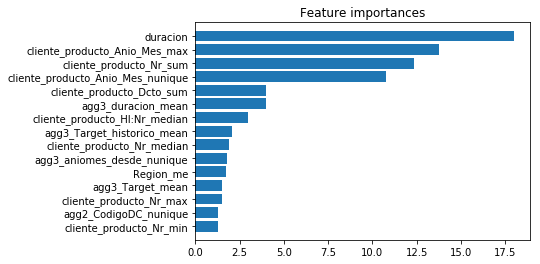

In [20]:
plot_importances(model,X_train,15)

## Output final

In [21]:
#Lectura de datos de test
test=pd.read_csv('Datasets/test.csv')

#Eliminación de columnas correlacionadas y IDs
to_model=test_set.drop(columns=columnas_drop+['Target','Marca','Cupo'])
to_model=to_model.drop(columns=correlated)

#Reentrenamiento del modelo con la data completa
model.fit(X,y)

#Predicciones
copia_test_set=test_set.copy()
copia_test_set['preds']=model.predict_proba(to_model)[:,-1]

t=copia_test_set.groupby(['Cliente','Cupo','Marca']).preds.max().reset_index()

test=test.merge(t,on=['Cliente','Marca','Cupo'],how='left')[['Cliente','Marca','Cupo',
                                                             'preds']].rename(columns={'preds':'Ejecuto_Promo'})

#Resultados finales
test.set_index('Cliente').to_csv('submission.csv')